In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
from copy import deepcopy
from numba import types as tps
from typing import Sequence, Tuple
from bisect import bisect_left
import torch.nn as nn
import torch
import time
from collections import defaultdict

from lobio.lob.limit_order import Order, AMOUNT_TICK, PRICE_TICK, EventType, OrderType, TraderId, Side
from lobio.lob.order_book import  OrderBook, OrderBookSimple, TOP_N, PriceLevelSimple
from lobio.utils.utils import group_diffs, group_historical_trades, group_orders, get_initial_order_book_trunc, \
                                get_initial_order_book_simple, get_initial_order_book_simple2
from queue_dynamic.models.reinforce_model import GaussianPDFModel, ModelPerceptron
from queue_dynamic.simulation import run_true_simulation, run_pred_simulation
from queue_dynamic.loss import calculate_loss

sns.set_theme(style="darkgrid")

%load_ext line_profiler
%load_ext autoreload
%autoreload 2

In [2]:
diffs_raw_file = "../data/diffs_raw.npy"
diffs_prepared_file = "../data/diffs_prepared.npy"
init_lob_raw_file = "../data/init_lob_raw.npy"
init_lob_prepared_file = "../data/init_lob_prepared.npy"
aggtrades_raw_file = "../data/aggtrades_raw.npy"
orders_prepared_file = "../data/orders_prepared.npy"
pl_to_enter_file = "../data/price_level_to_enter.npy"

with open(init_lob_raw_file, 'rb') as file:
    init_lob_raw = np.load(file)
with open(diffs_raw_file, 'rb') as file:
    diffs_raw = np.load(file)
with open(aggtrades_raw_file, 'rb') as file:
    aggtrades_raw = np.load(file)

with open(init_lob_prepared_file, 'rb') as file:
    init_lob = np.load(file)
with open(diffs_prepared_file, 'rb') as file:
    diffs = np.load(file)
with open(orders_prepared_file, 'rb') as file:
    orders = np.load(file)

with open(pl_to_enter_file, 'rb') as file:
    pl_to_enter = np.load(file)

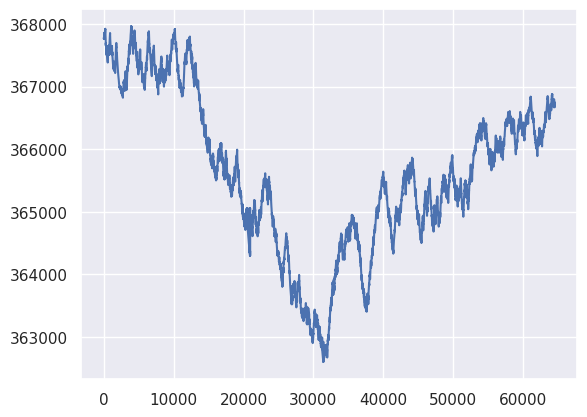

In [3]:
plt.plot(aggtrades_raw[:, 1])
plt.show()

In [4]:
diffs_grouped = group_diffs(diffs)
orders_per_diff = group_orders(orders, len(diffs_grouped))

100%|██████████| 23209/23209 [00:00<00:00, 286100.22it/s]


In [5]:
len(orders_per_diff), len(diffs_grouped)

(23209, 23209)

In [6]:
n_poses = len(pl_to_enter)

In [7]:
n_poses

4120

In [35]:
ob = get_initial_order_book_trunc(init_lob)
MAX_PAST_DIFFS = 30
last_bid_states = []
last_ask_states = []
last_pl_removed = []
possible_ts = []
difflives = defaultdict(int)

for i, diff in enumerate(tqdm(diffs_grouped)):
    last_bid_states.append((i, deepcopy(ob.bids)))
    last_ask_states.append((i, deepcopy(ob.asks)))
    if len(last_bid_states) > MAX_PAST_DIFFS:
        del last_bid_states[0]
    if len(last_ask_states) > MAX_PAST_DIFFS:
        del last_ask_states[0]

    cur_pl_removed = set()
    cur_orders = orders_per_diff[i]
    for _, order in cur_orders:
        if order.type == OrderType.MARKET:
            if len(ob.bids): # To track removed not best price leves
                prev_best_bid = ob.bids[0][0]
            if len(ob.asks): # To track removed not best price leves
                prev_best_ask = ob.asks[0][0]
            ob.set_market_order([order.quote, order.side])
            if order.side == Side.BUY and len(ob.asks):
                if ob.asks[0][0] == order.base: # if order not ate whole price level
                    is_found = False

                    ind = bisect_left(last_ask_states[-1][1], order.base, key=lambda x: x[0])
                    if ind == len(last_ask_states[-1][1]) or last_ask_states[-1][1][ind][0] != order.base:
                        is_found = True # to prevent adding - it is between diffs price level
                    else:
                        for j, (ts, last_ask) in enumerate(last_ask_states[-2::-1]):
                            if order.base in last_pl_removed[-j-1]:
                                difflives[j] += 1
                                is_found = True
                                if j != 0:
                                    possible_ts.append((ts+1, order.base, Side.SELL))
                                break
                            ind = bisect_left(last_ask, order.base, key=lambda x: x[0])
                            if ind == len(last_ask) or last_ask[ind][0] != order.base:
                                difflives[j] += 1
                                is_found = True
                                if j != 0:
                                    possible_ts.append((ts+1, order.base, Side.SELL))
                                break

                    if not is_found:
                        possible_ts.append((ts, order.base, Side.SELL))
                else:
                    cur_best_ask = ob.asks[0][0]
                    while cur_best_ask > prev_best_ask:
                        cur_pl_removed.add(prev_best_ask)
                        prev_best_ask += 1

            elif len(ob.bids):
                if ob.bids[0][0] == order.base: # if order not ate whole price level
                    is_found = False

                    ind = bisect_left(last_bid_states[-1][1], -order.base, key=lambda x: -x[0])
                    if ind == len(last_bid_states[-1][1]) or last_bid_states[-1][1][ind][0] != order.base:
                        is_found = True
                    else:
                        for j, (ts, last_bid) in enumerate(last_bid_states[-2::-1]):
                            if order.base in last_pl_removed[-j-1]:
                                difflives[j] += 1
                                is_found = True
                                if j != 0:
                                    possible_ts.append((ts+1, order.base, Side.BUY))
                                break
                            ind = bisect_left(last_bid, -order.base, key=lambda x: -x[0])
                            if ind == len(last_bid) or last_bid[ind][0] != order.base:
                                difflives[j] += 1
                                is_found = True
                                if j != 0:
                                    possible_ts.append((ts+1, order.base, Side.BUY))
                                break

                    if not is_found:
                        possible_ts.append((ts, order.base, Side.BUY))
                else:
                    cur_best_bid = ob.bids[0][0]
                    while cur_best_bid < prev_best_bid:
                        cur_pl_removed.add(prev_best_bid)
                        prev_best_bid -= 1
        else:
            ob.set_limit_order([order.base, order.quote, order.side])
    
    last_pl_removed.append(cur_pl_removed)
    if len(last_pl_removed) > MAX_PAST_DIFFS:
        del last_pl_removed[0]
    ob.apply_historical_update(diff)

possible_ts.sort(key=lambda x: (x[0], x[1], x[2]))

squeezed_ts = []
prev_info = None
for info in possible_ts:
    if info != prev_info:
        squeezed_ts.append(info)
        prev_info = info

100%|██████████| 23209/23209 [00:03<00:00, 6021.37it/s]


In [36]:
dict(sorted(difflives.items()))

{0: 2042,
 1: 1177,
 2: 880,
 3: 747,
 4: 616,
 5: 453,
 6: 376,
 7: 347,
 8: 292,
 9: 244,
 10: 221,
 11: 201,
 12: 158,
 13: 143,
 14: 127,
 15: 96,
 16: 93,
 17: 90,
 18: 82,
 19: 66,
 20: 77,
 21: 50,
 22: 49,
 23: 36,
 24: 36,
 25: 30,
 26: 35,
 27: 29,
 28: 30}

In [37]:
len(squeezed_ts)

4120

In [57]:
dim_observation=2
dim_action = 1
dim_hidden = 8
n_hidden_layers=1
std = 0.01
scale_factor = 1
gamma = 0.95
lr = 0.01
N_iter = 50
N_episode = 500
n_exp = 10

In [58]:
seed = int(round(np.random.uniform(0, 10), 5) * 10**5)
torch.manual_seed(seed)
rng = np.random.default_rng(seed)

model_perc = ModelPerceptron(dim_observation, dim_action, dim_hidden=dim_hidden, n_hidden_layers=n_hidden_layers)
rl_model = GaussianPDFModel(
    model=model_perc,
    dim_observation=dim_observation,
    dim_action=dim_action,
    action_bounds=np.array([[0, 1]]),
    scale_factor=scale_factor,
    std=std,
)
optimizer = torch.optim.SGD(rl_model.parameters(), lr=lr)

running_loss = []
running_reward = []
for i in tqdm(range(N_iter)):
    #samples = rng.choice(pl_to_enter, size=1000, replace=False, axis=0)
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples))

    optimizer.zero_grad()
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
    loss, reward = calculate_loss(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)
    running_loss.append(loss.item())
    running_reward.append(reward)

    loss.backward()
    optimizer.step()

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [03:29<00:00,  4.19s/it]


In [59]:
with torch.no_grad():
    samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
    samples_ind.sort()
    samples = pl_to_enter[samples_ind]
    place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples))
    poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
    poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
    loss, reward = calculate_loss(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)

print(reward)

0.9104477611940298


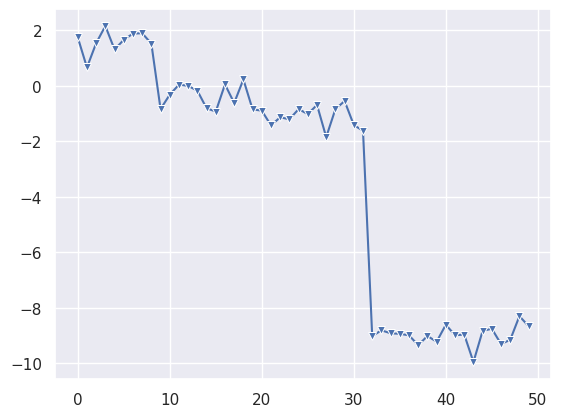

In [60]:
sns.lineplot(running_loss, marker='v')
plt.show()

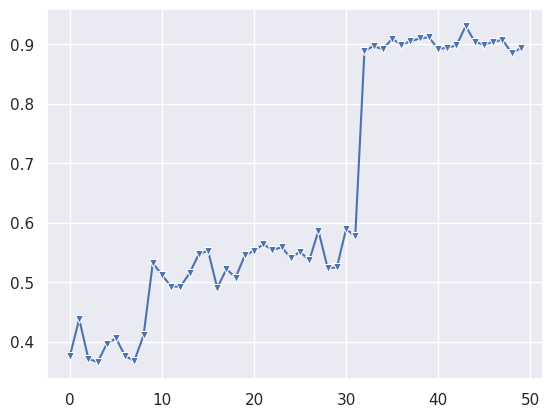

In [61]:
sns.lineplot(running_reward, marker='v')
plt.show()

In [50]:
params = {'dim_obs': dim_observation, 
          'dim_act': dim_action, 
          'dim_hid': dim_hidden,
          'n_hid_layers': n_hidden_layers,
          'std': std, 
          'scale_factor': scale_factor,
          'gamma': gamma,
          'lr': lr,
          'N_iter': N_iter,
          'N_episod': N_episode,
          'n_exp': n_exp
          }
seeds = []
running_losses = []
running_rewards = []

for _ in range(n_exp):
    seed = int(round(np.random.uniform(0, 10), 5) * 10**5)
    torch.manual_seed(seed)
    rng = np.random.default_rng(seed)
    seeds.append(seed)

    model_perc = ModelPerceptron(dim_observation, dim_action, dim_hidden=dim_hidden, n_hidden_layers=n_hidden_layers)
    rl_model = GaussianPDFModel(
        model=model_perc,
        dim_observation=dim_observation,
        dim_action=dim_action,
        action_bounds=np.array([[0, 1]]),
        scale_factor=scale_factor,
        std=std,
    )
    optimizer = torch.optim.SGD(rl_model.parameters(), lr=lr)

    running_loss = []
    running_reward = []
    for i in tqdm(range(N_iter)):
        #samples = rng.choice(pl_to_enter, size=1000, replace=False, axis=0)
        samples_ind = np.unique(rng.integers(0, n_poses, size=N_episode))
        samples_ind.sort()
        samples = pl_to_enter[samples_ind]
        place_ratios = np.zeros(len(samples))#rng.uniform(0, 0.3, size=len(samples))#rng.triangular(0, 0.1, 1, size=len(samples))

        optimizer.zero_grad()
        poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
        poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rl_model)
        loss, reward = calculate_loss(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)
        running_loss.append(loss.item())
        running_reward.append(reward)

        loss.backward()
        optimizer.step()
    running_losses.append(running_loss)
    running_rewards.append(running_reward)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [02:48<00:00,  3.37s/it]


In [51]:
save_dir = f'../experiments/exp{2}/'
with open(save_dir + 'hypers.pkl', 'wb') as f:
    pickle.dump(params, f)
with open(save_dir + 'seeds.npy', 'wb') as f:
    np.save(f, seeds)
with open(save_dir + 'losses.npy', 'wb') as f:
    np.save(f, running_losses)
with open(save_dir + 'rewards.npy', 'wb') as f:
    np.save(f, running_rewards)

In [52]:
save_dir = f'../experiments/exp{2}/'
with open(save_dir + 'hypers.pkl', 'rb') as f:
    params = pickle.load(f)
with open(save_dir + 'seeds.npy', 'rb') as f:
    seeds = np.load(f)
with open(save_dir + 'losses.npy', 'rb') as f:
    losses = np.load(f)
with open(save_dir + 'rewards.npy', 'rb') as f:
    rewards = np.load(f)

In [53]:
loss_df = pd.DataFrame({'loss': losses.reshape(-1, ), 'iter': 1 + np.tile(np.arange(losses.shape[1]), losses.shape[0])})
reward_df = pd.DataFrame({'reward': rewards.reshape(-1, ), 'iter': 1 + np.tile(np.arange(rewards.shape[1]), rewards.shape[0])})

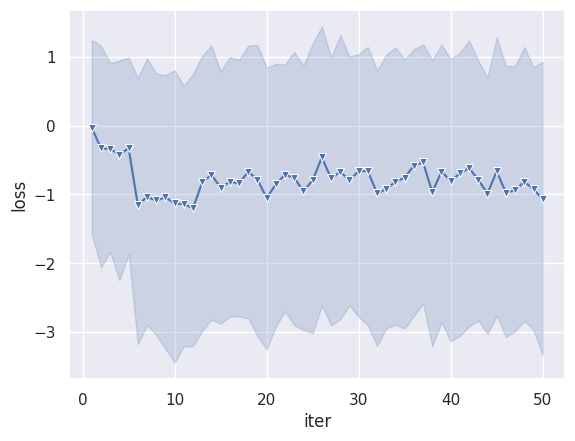

In [56]:
sns.lineplot(loss_df, marker='v', x='iter', y='loss')
# plt.yscale('log')
plt.show()

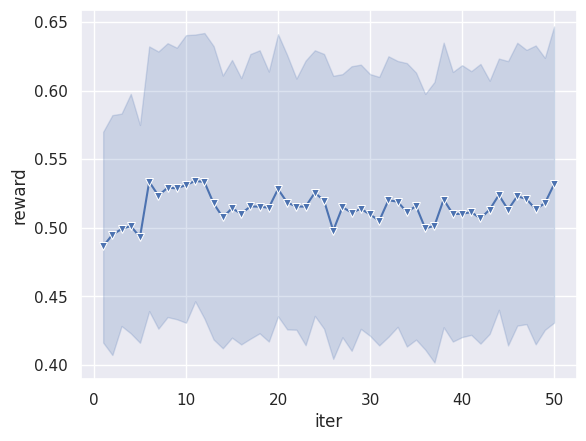

In [55]:
sns.lineplot(reward_df, marker='v', x='iter', y='reward')
plt.show()

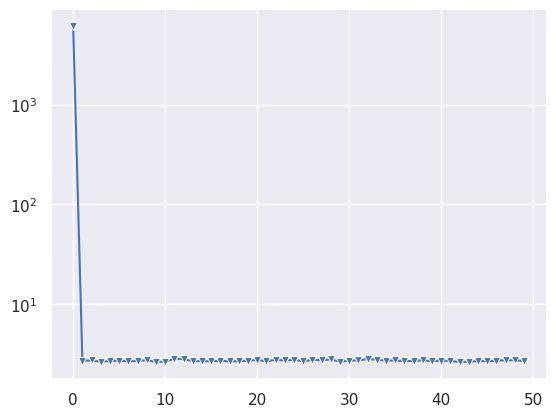

In [120]:
sns.lineplot(running_loss, marker='v')
plt.yscale('log')
plt.show()

In [33]:
samples_ind = np.unique(np.random.randint(0, n_poses, size=500))
samples_ind.sort()
samples = pl_to_enter[samples_ind]
place_ratios = np.zeros(len(samples))

poses_true_info = run_true_simulation(init_lob, diffs_grouped, orders_per_diff, samples, place_ratios, rng)
poses_pred_info, obs_actions = run_pred_simulation(init_lob, diffs_grouped, orders_per_diff,samples, place_ratios, rl_model)
loss = calculate_loss(poses_true_info, poses_pred_info, obs_actions, rl_model, gamma)

In [35]:
loss

tensor(2.6927, grad_fn=<DivBackward0>)

In [151]:
poses_true_info = run_true_simulation(control_samples, control_place_ratios, rng)
poses_pred_info, obs_actions = run_pred_simulation(control_samples, control_place_ratios, rl_model)

num_eq = 0
for a,b in zip(poses_true_info, poses_pred_info):
    num_eq += a == b

len(poses_true_info), len(poses_pred_info), num_eq

(917, 917, 692)

In [154]:
poses_true_info = run_true_simulation(control_samples, control_place_ratios, rng)
poses_pred_info, obs_actions = run_pred_simulation(control_samples, control_place_ratios, rl_model)

num_eq = 0
for a,b in zip(poses_true_info, poses_pred_info):
    num_eq += a == b

len(poses_true_info), len(poses_pred_info), num_eq

(917, 917, 696)

In [157]:
poses_true_info = run_true_simulation(control_samples, control_place_ratios, rng)
poses_pred_info, obs_actions = run_pred_simulation(control_samples, control_place_ratios, rl_model)

num_eq = 0
for a,b in zip(poses_true_info, poses_pred_info):
    num_eq += a == b

len(poses_true_info), len(poses_pred_info), num_eq

(917, 917, 697)

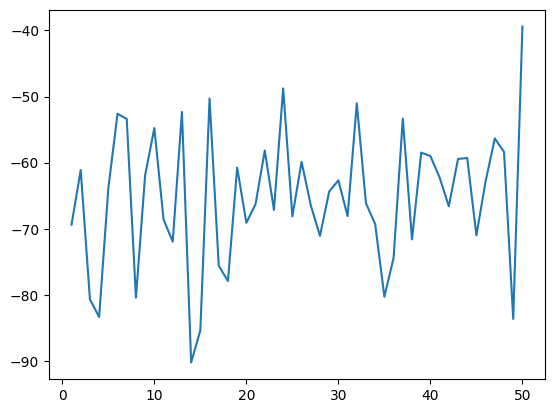

In [158]:
plt.plot(running_loss)
plt.show()

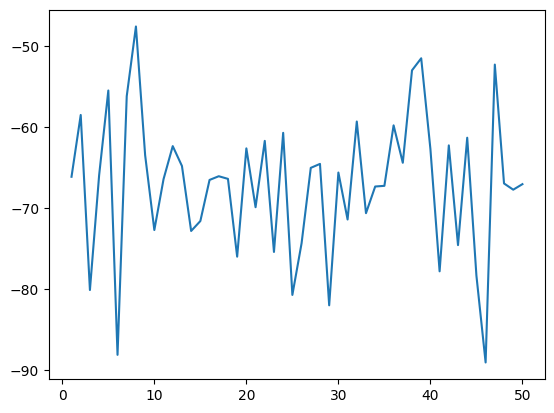

In [155]:
plt.plot(running_loss)
plt.show()

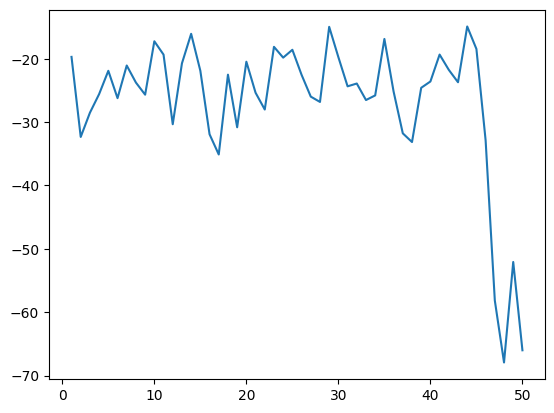

In [152]:
plt.plot(running_loss)
plt.show()

In [80]:
loss

tensor(-63.4452, grad_fn=<DivBackward0>)

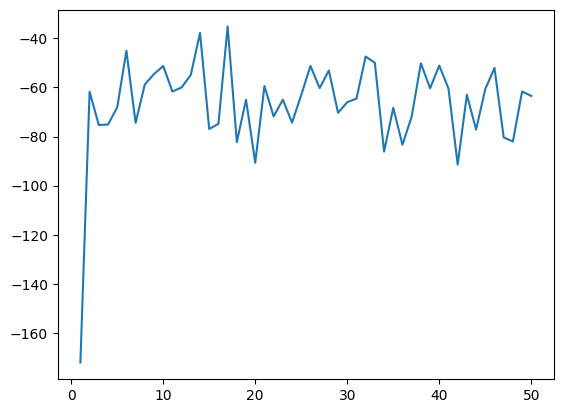

In [81]:
plt.plot(running_loss)
plt.show()

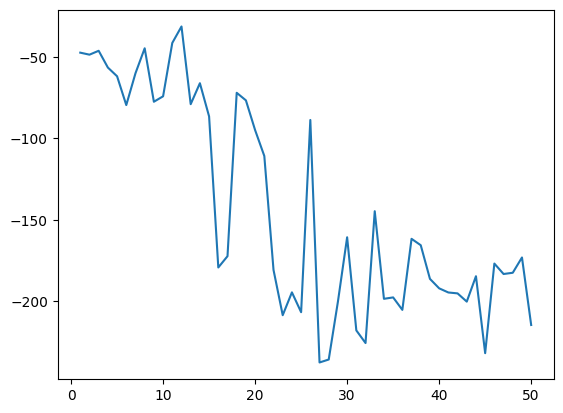

In [75]:
plt.plot(running_loss)
plt.show()

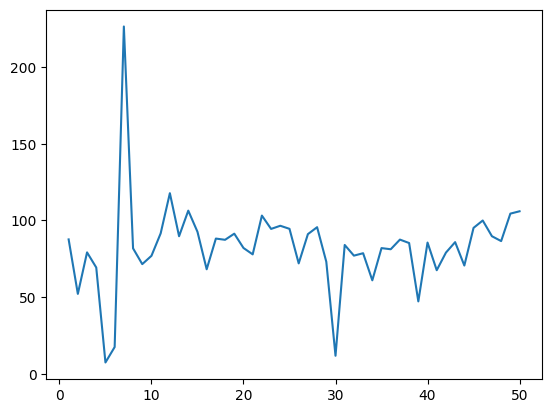

In [60]:
plt.plot(running_loss)
plt.show()

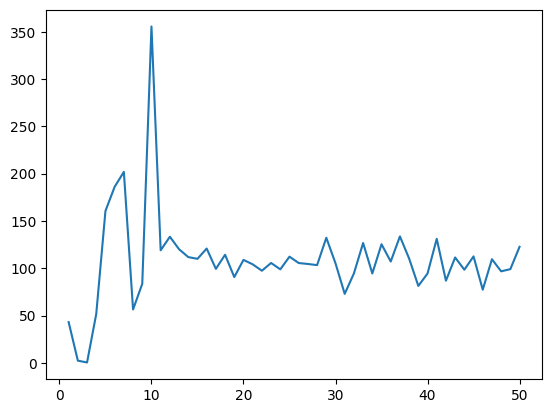

In [53]:
plt.plot(running_loss)
plt.show()

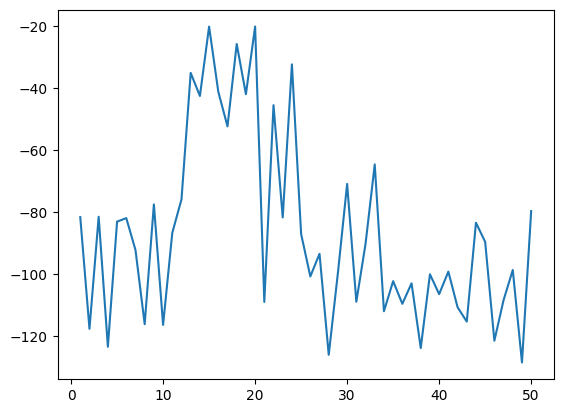

In [74]:
plt.plot(running_loss) # 8 hid dim
plt.show()

In [75]:
rl_model

GaussianPDFModel(
  (perceptron): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

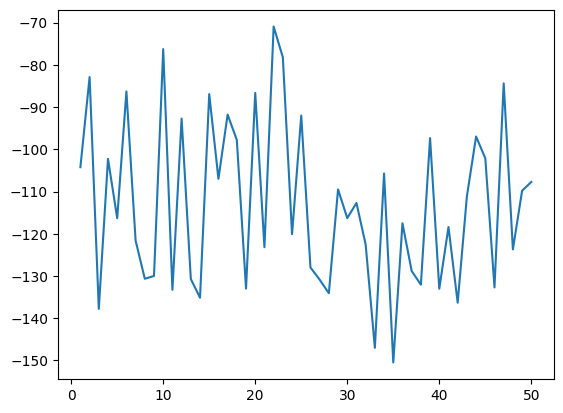

In [70]:
plt.plot(running_loss) # lin reg
plt.show()

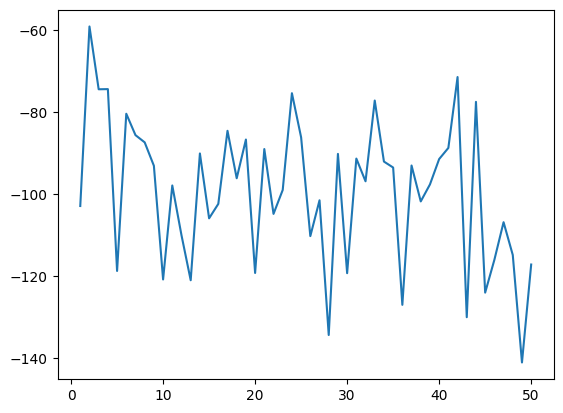

In [65]:
plt.plot(running_loss) # lin reg
plt.show()

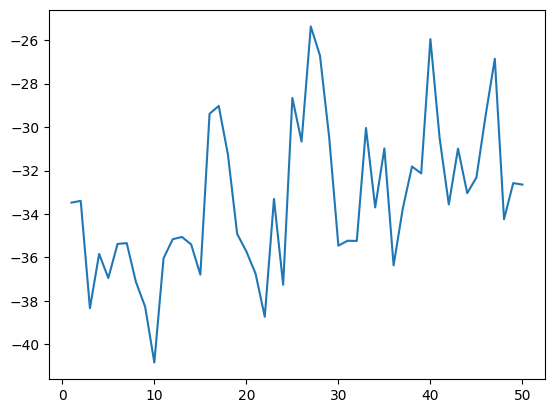

In [62]:
plt.plot(running_loss) # 16!
plt.show()

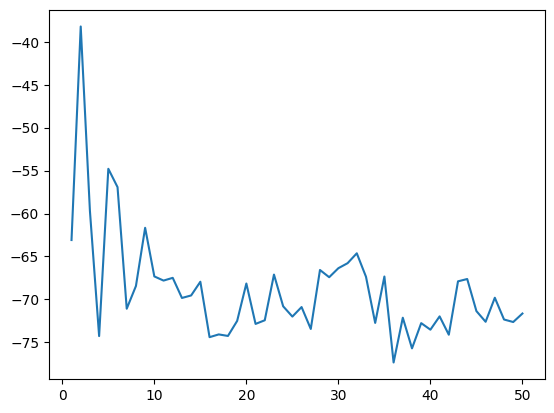

In [59]:
plt.plot(running_loss)
plt.show()

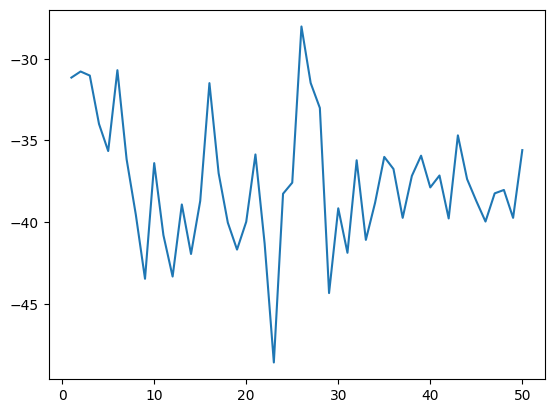

In [52]:
plt.plot(running_loss) # fixed free reward
plt.show()

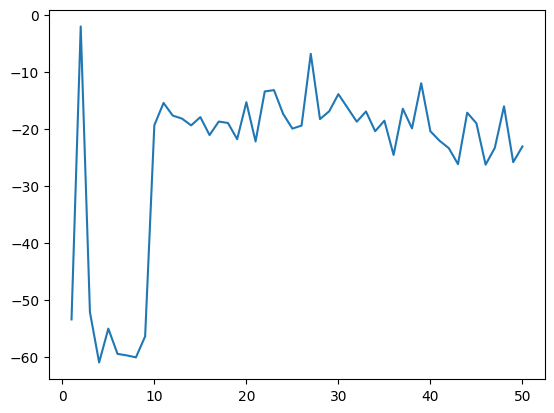

In [36]:
plt.plot(running_loss) # lr 0.005 Nones removed
plt.show()

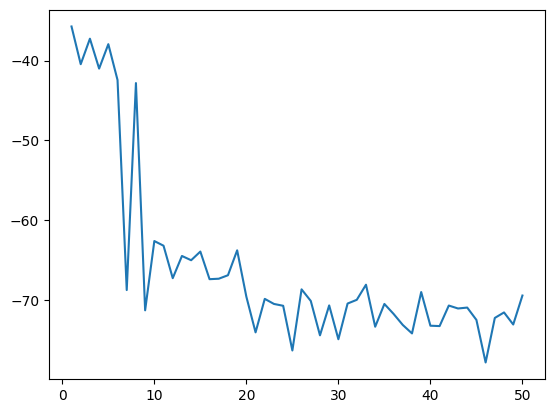

In [28]:
plt.plot(running_loss) # lr 0.005
plt.show()

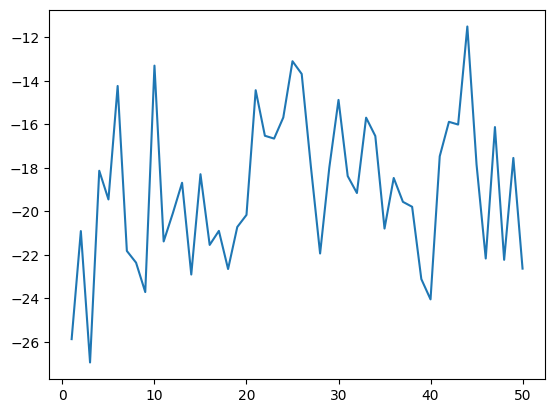

In [24]:
plt.plot(running_loss) # lr 0.01
plt.show()

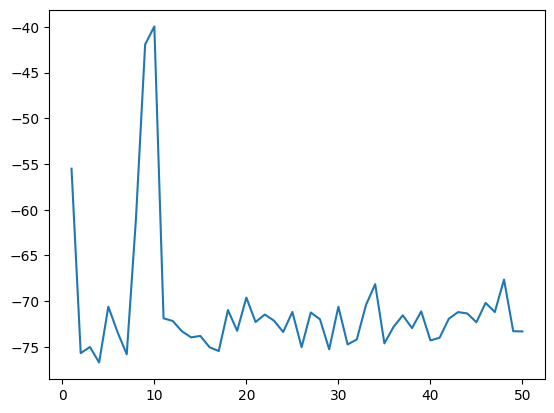

In [21]:
plt.plot(running_loss)# - rew
plt.show()

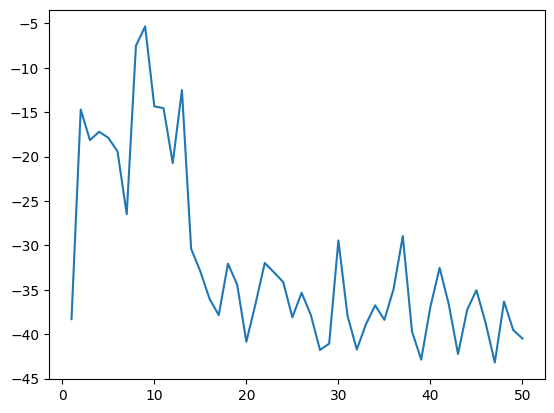

In [13]:
plt.plot(running_loss)
plt.show()

In [22]:
samples_ind = np.unique(np.random.randint(0, n_poses, size=1000))
samples_ind.sort()
samples = pl_to_enter[samples_ind]
place_ratios = rng.triangular(0, 0.1, 1, size=len(samples))

poses_true_info = run_true_simulation(samples, place_ratios, rng)
poses_pred_info, obs_actions = run_pred_simulation(samples, place_ratios, rl_model)
loss = calculate_loss(poses_true_info, poses_pred_info, obs_actions, gamma, rl_model)

print(loss)

tensor(-1.9954, grad_fn=<DivBackward0>)


In [357]:
for ind, p_l in enumerate(ob2.asks):
    assert p_l[0] == ob.asks[ind].base
    assert p_l[1] == ob.asks[ind].total_amount()

for ind, p_l in enumerate(ob2.bids):
    assert p_l[0] == ob.bids[ind].base
    assert p_l[1] == ob.bids[ind].total_amount()

100%|██████████| 20/20 [00:00<00:00, 23871.96it/s]


In [223]:
pl_to_enter # filter? remove those who live 1-2 diffs

array([[     0, 367769,      1],
       [     0, 367798,      1],
       [     2, 367766,     -1],
       ...,
       [ 23173, 366702,      1],
       [ 23175, 366750,      1],
       [ 23195, 366749,     -1]])

In [512]:
tmp = range(10)

In [513]:
rng = np.random.default_rng()

In [526]:
times_tr = []
for _ in range(10**5):
    start = time.time_ns()
    q = rng.beta(1.5, 12, size=len(tmp))
    for j, i in enumerate(tmp):
        q[j]
    end = time.time_ns()
    times_tr.append(end - start)

times_uni = []
for _ in range(10**5):
    start = time.time_ns()
    for i in tmp:
        rng.beta(1.5, 12)
    end = time.time_ns()
    times_uni.append(end - start)

In [527]:
np.mean(times_tr), np.std(times_tr)

(5301.56705, 11377.838603988204)

In [528]:
np.mean(times_uni), np.std(times_uni)

(14785.18414, 77330.03937265539)

In [135]:
rng.triangular(0, 0.15, 1)

0.3931968057873262

In [45]:
diffs_prep_grouped = group_diffs(diffs)
orders_prep_grouped = group_orders(orders, len(diffs_prep_grouped))

  0%|          | 0/23163 [00:00<?, ?it/s]

100%|██████████| 23163/23163 [00:00<00:00, 256035.48it/s]


In [60]:
# ob1 = get_initial_order_book_simple(init_lob_prepared)
# ob2 = get_initial_order_book_simple(init_lob_prepared)

# for i, diff in enumerate(tqdm(diffs_prep_grouped)):
#     cur_orders = orders_prep_grouped[i]
#     for ts, order in cur_orders:
#         if order.type == OrderType.MARKET:
#             ob1.set_market_order([order.quote, order.side])
#             ob2.set_market_order([order.quote, order.side])
#         else:
#             ob1.set_limit_order([order.base, order.quote, order.side])
#             ob2.set_limit_order([order.base, order.quote, order.side])

#     ob1.apply_historical_update(diff)
#     ob2.apply_historical_update(diffs_cut[i])
#     del ob2.bids[TOP_N:]
#     del ob2.asks[TOP_N:]

#     assert ob1.bids[:TOP_N] == ob2.bids[:TOP_N]
#     assert ob1.asks[:TOP_N] == ob2.asks[:TOP_N]

100%|██████████| 23209/23209 [00:15<00:00, 1547.09it/s]


In [50]:
# diffs_grouped = group_diffs(diffs_raw)
# diffs_prep_grouped = group_diffs(diffs)
# orders_prep_grouped = group_orders(orders, len(diffs_prep_grouped))

# ob1 = get_initial_order_book_simple(init_lob)
# ob2 = get_initial_order_book_simple(init_lob_raw)

# for i, diff in enumerate(tqdm(diffs_prep_grouped)):
#     cur_orders = orders_prep_grouped[i]
#     for ts, order in cur_orders:
#         if order.type == OrderType.MARKET:
#             ob1.set_market_order([order.quote, order.side])
#         else:
#             ob1.set_limit_order([order.base, order.quote, order.side])
    
#     ob1.apply_historical_update(diff)
#     ob2.apply_historical_update(diffs_grouped[i])

# assert ob1 == ob2

100%|██████████| 23209/23209 [00:25<00:00, 922.29it/s] 


In [30]:
# ob1 = get_initial_order_book_simple(init_lob)
# ob1.top_n = 500
# ob2 = get_initial_order_book_simple(init_lob)
# ob2.top_n = 200
# mid_prices1 = []
# mid_prices2 = []
# for i, diff in enumerate(tqdm(diffs_prep_grouped)):
#     cur_orders = orders_prep_grouped[i]
#     for ts, order in cur_orders:
#         if order.type == OrderType.MARKET:
#             ob2.set_market_order([order.quote, order.side])
#             ob1.set_market_order([order.quote, order.side])
#         else:
#             ob2.set_limit_order([order.base, order.quote, order.side])
#             ob1.set_limit_order([order.base, order.quote, order.side])
#     ob2.apply_historical_update(diff)
#     ob1.apply_historical_update(diff)
#     mid_prices1.append(ob1.bids[0][0] + ob1.asks[0][0])
#     mid_prices2.append(ob2.bids[0][0] + ob2.asks[0][0])
#     # assert ob1.bids[:10] == ob2.bids[:10]
#     # assert ob1.asks[:10] == ob2.asks[:10]

  0%|          | 0/23209 [00:00<?, ?it/s]

100%|██████████| 23209/23209 [00:11<00:00, 2027.36it/s]


In [31]:
# dif_ind = []
# for i, pr in enumerate(mid_prices1):
#     if pr != mid_prices2[i]:
#         dif_ind.append(i)

In [32]:
# len(dif_ind)

10

In [6]:
diffs_grouped = group_diffs(diffs_raw)

100%|██████████| 23209/23209 [00:02<00:00, 8249.07it/s] 


In [8]:
bid_downs = []
ask_ups = []

for diff in diffs_grouped:
    cur_bid_down = 0
    cur_ask_up = 0
    for bid in diff[1]:
        if bid[1] == 0:
            cur_bid_down += 1
        else:
            break
    
    for ask in diff[2]:
        if ask[1] == 0:
            cur_ask_up += 1
        else:
            break
    
    bid_downs.append(cur_bid_down)
    ask_ups.append(cur_ask_up)

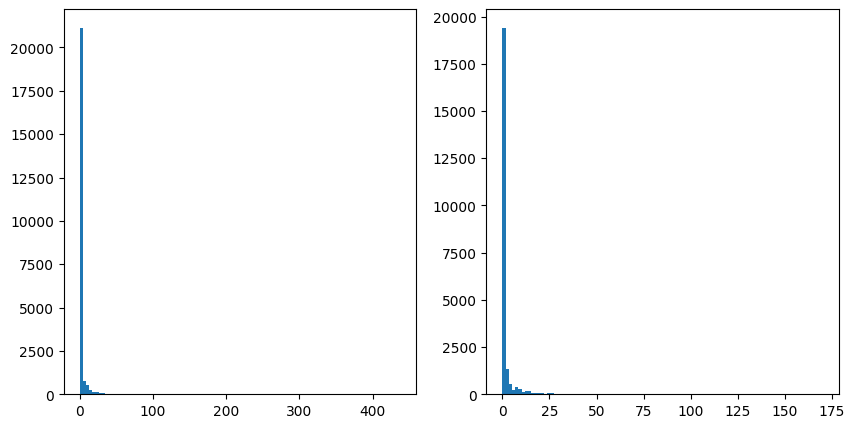

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].hist(bid_downs, bins=100)
axes[1].hist(ask_ups, bins=100)

plt.show()

In [12]:
print(np.max(bid_downs), np.median(bid_downs), np.mean(bid_downs))
print(np.max(ask_ups), np.median(ask_ups), np.mean(ask_ups))

437 0.0 1.7195053642983325
170 0.0 1.5846008014132449


In [6]:
diffs_grouped = group_diffs(diffs_raw)
diffs_prepared_grouped = group_diffs(diffs)
trades_grouped = group_historical_trades(aggtrades_raw, diffs_grouped)

In [8]:
buy_moves = []
sell_moves = []

for i, cur_trades in enumerate(trades_grouped):
    cur_buy_prices = []
    cur_sell_prices = []
    for trade in cur_trades:
        if trade[3] == Side.BUY:
            cur_buy_prices.append(trade[1])
        else:
            cur_sell_prices.append(trade[1])
    
    if len(cur_buy_prices):
        buy_moves.append(np.max(cur_buy_prices) - np.min(cur_buy_prices))
    else:
        buy_moves.append(0)

    if len(cur_sell_prices):
        sell_moves.append(np.max(cur_sell_prices) - np.min(cur_sell_prices))
    else:
        sell_moves.append(0)

In [9]:
np.argmax(buy_moves), np.argmax(sell_moves), np.max(buy_moves), np.max(sell_moves)

(7359, 7360, 473, 705)

In [13]:
bids_updates_lens = []
asks_updates_lens = []

for diff in diffs_grouped:
    bids_updates_lens.append(len(diff[1]))
    asks_updates_lens.append(len(diff[2]))

bids2_updates_lens = []
asks2_updates_lens = []

for diff in diffs_prepared_grouped:
    bids2_updates_lens.append(len(diff[1]))
    asks2_updates_lens.append(len(diff[2]))

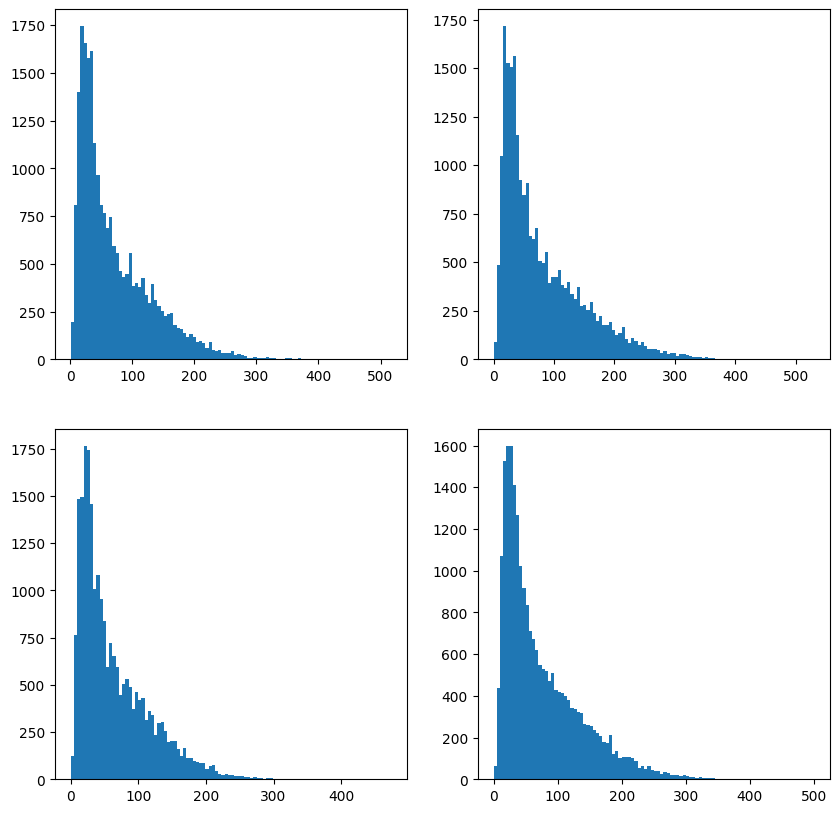

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes[0][0].hist(bids_updates_lens, bins=100)
axes[0][1].hist(asks_updates_lens, bins=100)
axes[1][0].hist(bids2_updates_lens, bins=100)
axes[1][1].hist(asks2_updates_lens, bins=100)

plt.show()